## Cross-correlation exmple with Active-Provenance in dispel4py:



### Sample Corss-Correlation Workflow: Description and Components
<br/>

The workflow performs and visualises the cross correlation matrix between a configurable number of sources, with parametrisable sampling-rate and length of the message.

The workflow specification and especially its parametrisation are inspired by the following research paper:
https://www.cs.ubc.ca/~hoos/Publ/RosEtAl07.pdf

#### Components
<br/>

<li>1 - Class Start: Root node of the graph. It sends initial configruation parameters (Number of total number produced) </li>
<li>2 - Class Source: Produces random number from 0,100 at a specified sampling-rate</i>
<li>3 - Class CorrCoef: Calculates the Pearson's correlation coefficient of a specified amount of samples (batch) coming from two sourcs</li>
<li>4 - Class PlotCor: Visualise the cross correlation matrix for all Sources for each batch</li>

The script below defines the components and declares the workflow. Its execution will show a visual representation of the abstract workfkow grap.


### Function addToProvState 
Adds an object and its metadata to the PEs state. This can be referenced from the user during write operations, increasing the lineage precision in stateful components.

The accepted parameters are the following:

#### Unnamed parameters:
<li> 1 - <i>data</i>: object to be stored in the provenance state</li>

#### Named Parameters:
<li> 1 - <i>name</i>: for stateful references a name of the object is required. Using the same name will overwrite the reference</li>
<li> 2 - <i>location</i>: url or path indicating the location of the data file, if any has been produced</li>
<li> 3 - <i>metadata</i>: dictionary of key,values pairs od user-defined metadata associated to the object.</li>
<li> 4 - <i>ignore_dep</i>: If <b>True</b> the dependencies which are currently standing are ignored, default True</li>
<li> 5 - <i>stateless</i>:  If <b>True</b> the item added is not included as new standing dependencies, default True</li>



<br/>


In [16]:
%matplotlib inline

from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *
from dispel4py.new.processor  import *
import time
import random
import numpy
import traceback 
from dispel4py.base import create_iterative_chain, GenericPE, ConsumerPE, IterativePE, SimpleFunctionPE
from dispel4py.new.simple_process import process_and_return

import IPython
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 


sns.set(style="white")


class Start(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('iterations')
        self._add_output('output')
        #self.prov_cluster="myne"
    
    def _process(self,inputs):
        
        if 'iterations' in inputs:
            inp=inputs['iterations']
             
            self.write('output',inp,metadata={'val':inp})
            
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'

class Source(GenericPE):

    def __init__(self,sr,index):
        GenericPE.__init__(self)
        self._add_input('iterations')
        self._add_output('output')
        self.sr=sr
        self.var_index=index
        #self.prov_cluster="myne"
         
        self.parameters={'sampling_rate':sr}
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'
        
    
    def _process(self,inputs):
         
        if 'iterations' in inputs:
            iteration=inputs['iterations'][0]
       
        #Streams out values at 1/self.sr sampling rate, until iteration>0
        while (iteration>0):
            val=random.uniform(0,100)
            time.sleep(1/self.sr)
            self.write('output',val,metadata={'val':val,'var_index':self.var_index})
            iteration-=1
        
        
        

class PlotData(GenericPE):

    def __init__(self,variables_number):
        GenericPE.__init__(self)
         
        self._add_output('output')
        self.size=variables_number
        self.parameters={'variables_number':variables_number}
        self.data={}
         
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'self.prov_cluster='mycluster'
            
    def _process(self,data):
        for x in data:
            
            if data[x][1] not in self.data:
                #prepares the data to visualise the xcor matrix of a specific batch number.
                self.data[data[x][1]]={}
                self.data[data[x][1]]['matrix']=numpy.identity(self.size)
                self.data[data[x][1]]['ro_count']=0
            
            self.data[data[x][1]]['matrix'][(data[x][2][1],data[x][2][0])]=data[x][0]
            self.data[data[x][1]]['ro_count']+=1
            
            if self.data[data[x][1]]['ro_count']==(self.size*(self.size-1))/2:
                
                d = pd.DataFrame(data=self.data[data[x][1]]['matrix'],
                 columns=range(0,self.size),index=range(0,self.size))
                
                mask = numpy.zeros_like(d, dtype=numpy.bool)
                mask[numpy.triu_indices_from(mask)] = True

                # Set up the matplotlib figure
                f, ax = plt.subplots(figsize=(11, 9))

                # Generate a custom diverging colormap
                cmap = sns.diverging_palette(220, 10, as_cmap=True)

                # Draw the heatmap with the mask and correct aspect ratio
                sns.heatmap(d, mask=mask, cmap=cmap, vmax=1,
                    square=True,
                    linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
                
                sns.plt.show()   
                self.log(d)
                self.write('output',d,metadata={'matrix':str(d),'batch':str(data[x][1])})
                
            
class CorrCoef(GenericPE):

    def __init__(self,batch_size,index):
        GenericPE.__init__(self)
        self._add_input('input1')
        self._add_input('input2')
        self._add_output('output')
        self.index1=0
        self.index2=0
        self.batch1=[]
        self.batch2=[]
        self.size=batch_size
        self.parameters={'batch_size':batch_size}
        self.index=index
        self.batchnum=0
         
        
    def _process(self, inputs):
        index=None
        val=None
              
            
        try:
            val = inputs['input1']
            self.batch1.append(val)
            self.addToProvState(self.batch1,name='batch1',metadata={'batch1':str(self.batch1)},ignore_dep=False)
        
            
                 
        except KeyError:
            #traceback.print_exc(file=sys.stderr)
            val = inputs['input2']
            self.batch2.append(val)
            self.addToProvState(self.batch2,name='batch2',metadata={'batch2':str(self.batch2)},ignore_dep=False)
        
        
        #self.addToProvState(None,,ignore_dep=False)
            
        if len(self.batch2)>=self.size and len(self.batch1)>=self.size:
            array1=numpy.array(self.batch1[0:self.size])
            array2=numpy.array(self.batch2[0:self.size])
            ro=numpy.corrcoef([array1,array2])
            # stream out the correlation coefficient, the sequence number of the batch and the indexes of the sources.
            self.write('output',(ro[0][1],self.batchnum,self.index),metadata={'batchnum':self.batchnum,'ro':str(ro[0][1]),'array1':str(array1),'array2':str(array2),'source_index':self.index},dep=['batch1','batch2'])
            self.batchnum+=1
            self.batch1=self.batch1[(self.size):len(self.batch1)]
            self.batch2=self.batch2[(self.size):len(self.batch2)]
 





### Preparing workflow inputs and parameters

<b>number of visualisations</b> = <i>iterations/batch_size</i> at speed defined by the <i>sampling_rate<i>

SETTING NAME: PlotData
SETTING NAME: Start
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef


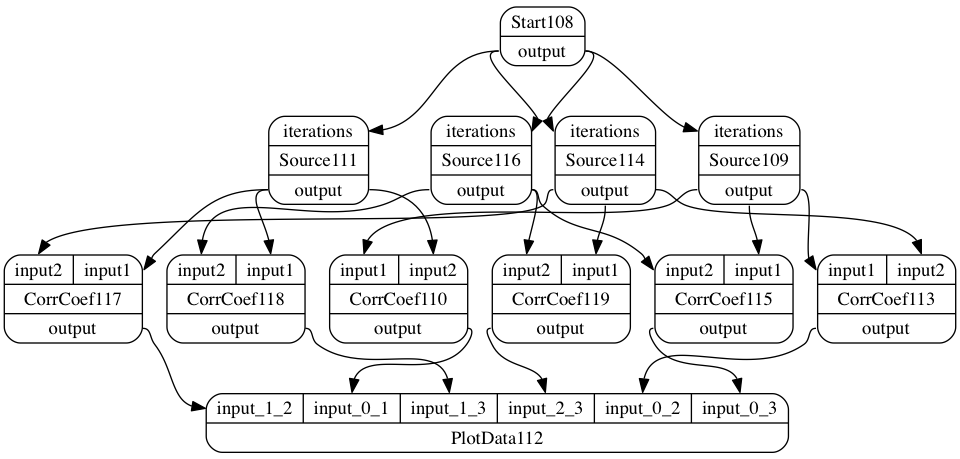

Preparing for: 3 projections


In [17]:
#####################################################################################################

#Declare workflow inputs: (each iteration prduces a batch_size of samples at the specified sampling_rate)
# number of projections = iterations/batch_size at speed defined by sampling rate
variables_number=4
sampling_rate=100
batch_size=5
iterations=15

input_data = {"Start": [{"iterations": [iterations]}]}
      
# Instantiates the Workflow Components  
# and generates the graph based on parameters

sources={}
graph = WorkflowGraph()
plot=PlotData(variables_number)    
start=Start()   

for i in range(0,variables_number):
    sources[i] = Source(sampling_rate,i)

for h in range(0,variables_number):
    graph.connect(start,'output',sources[h],'iterations')
    for j in range(h+1,variables_number):
        cc=CorrCoef(batch_size,(h,j))
        plot._add_input('input'+'_'+str(h)+'_'+str(j),grouping=[1])
        graph.connect(sources[h],'output',cc,'input1')
        graph.connect(sources[j],'output',cc,'input2')
        graph.connect(cc,'output',plot,'input'+'_'+str(h)+'_'+str(j))
        cc.numprocesses=1
        

#Visualise the graph
from dispel4py.visualisation import display
display(graph)

print ("Preparing for: "+str(iterations/batch_size)+" projections" )

## Preparing the workflow graph for provenance production, pre-analysis and storage

This snippet will make sure that the workflow compoentns will be provenance-aware and the lineage information sent to the designated ProvenanceRecorders for in-workflow pre-analysis.

The execution will show a new graph where it will be possible to validate the provenance-cluster, if any, and the correct association of ProvenanceRecorders and feedback connections.

The graph will change according to the declaration of self.prov_cluster property of the processing elements and to the specification of different ProvenanceRecorders and feedback loops, as described below:

### Function InitiateNewRun 
Prepares the workflow with the required provenance mechanisms
The accepted parameters are the following:

#### Unnamed parameters:
<li> 1 - <i>worfklow graph</i></li>
<li> 2 - Class name implementing the default <i>ProvenanceRecorder</i></li>

#### Named Parameters
<li> 3 - <i>provImpClass</i>: Class name extending the default <i>ProvenancePE</i>. The current type of the workflow components (GenericPE) will be extended with the one indicated by the <i>provImpClass</i> type</li>
<li> 4 - <i>username</i></li>
<li> 5 - <i>runId</i></li>
<li> 6 - <i>w3c_prov</i>: specifies if the PE will outupt lineage in PROV format (default=False)</li>
<li> 7 - <i>workflowName</i></li>
<li> 8 - <i>workflowId</i></li>
<li> 9 - <i>clustersRecorders</i>: dictionary associating <i>provenance-clusters</i> with a specific <i>ProvenanceRecorder</i> (overrides the default <i>ProvenanceRecorder</i>) </li>
<li> 10 - <i>feedbackPEs</i>: list of PE names receiving and processing feedbacks from the <i>ProvenanceRecorder</i>. </li>

<br/>




SETTING NAME: NewWorkflowRun
SETTING NAME: ProvenanceRecorderToServiceBulk
Inputs: {'NewWorkflowRun': [{'input': 'None'}]}
SETTING NAME: SimpleProcessingPE
RUN Metadata: {'username': 'aspinuso', 'workflowId': 'xx', 'description': '', 'mapping': '-f', 'system_id': None, 'runId': 'RDWD_orfeus-as-99202-765627d1-5dc1-11e6-9a8f-f45c89acf865', 'startTime': '2016-08-08 23:40:17.682334', 'input': [], '_id': 'RDWD_orfeus-as-99202-765627d1-5dc1-11e6-9a8f-f45c89acf865', 'type': 'workflow_run', 'workflowName': 'test_rdwd'}
SimplePE: Processed 1 iteration.
Outputs: {}
Change grouping implementation 
Change grouping implementation 
Injecting provenance to: CorrCoef Original type: (<class 'dispel4py.core.GenericPE'>,)
Injecting provenance to: CorrCoef Transoformed: <class 'dispel4py.provenance.<class '__main__.CorrCoef'>'>
Change grouping implementation 
Injecting provenance to: CorrCoef Original type: (<class 'dispel4py.core.GenericPE'>,)
Injecting provenance to: CorrCoef Transoformed: <class 'dispe

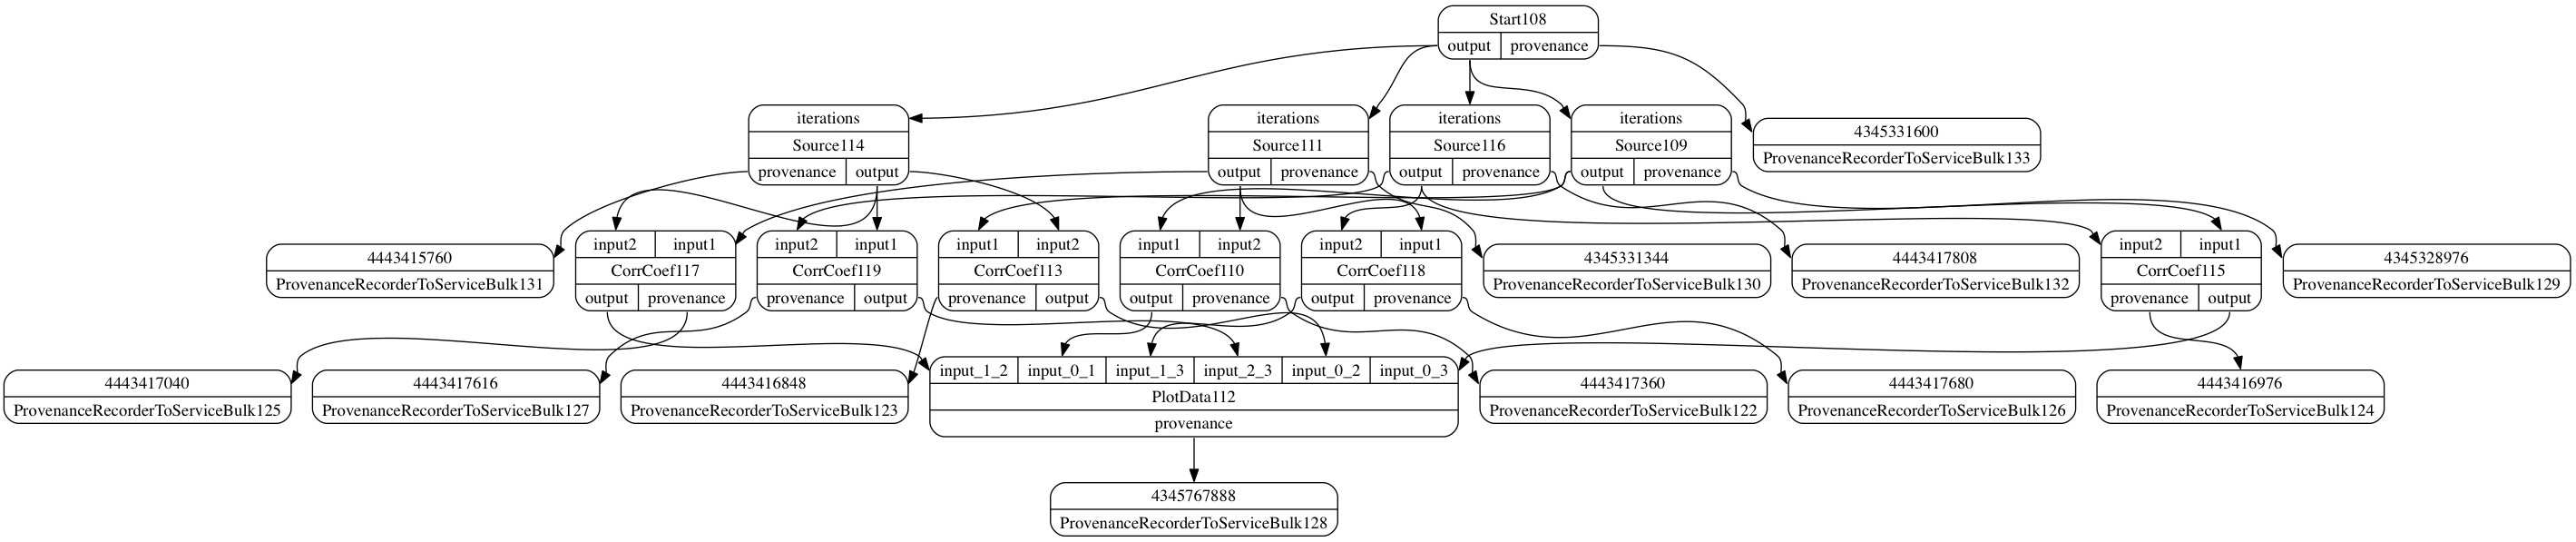

In [18]:
#Location of the remote repository for runtime updates of the lineage traces. Shared among ProvenanceRecorder subtypes
ProvenanceRecorder.REPOS_URL='http://localhost/workflow/insert'

# Ranomdly generated unique identifier for the current run
rid='RDWD_'+getUniqueId()

# if ProvenanceRecorderToFile is used, this path will contains all the resulting JSON documents
os.environ['PROV_PATH']="./prov-files/"

# Finally, provenance enhanced graph is prepared:
InitiateNewRun(graph,ProvenanceRecorderToServiceBulk,provImpClass=ProvenancePE,username='aspinuso',runId=rid,w3c_prov=False,workflowName="test_rdwd",workflowId="xx")

#.. and visualised..
display(graph)

### Execution
The followin instruction executes the workfklow in single-process mode
<br/>

SETTING NAME: SimpleProcessingPE


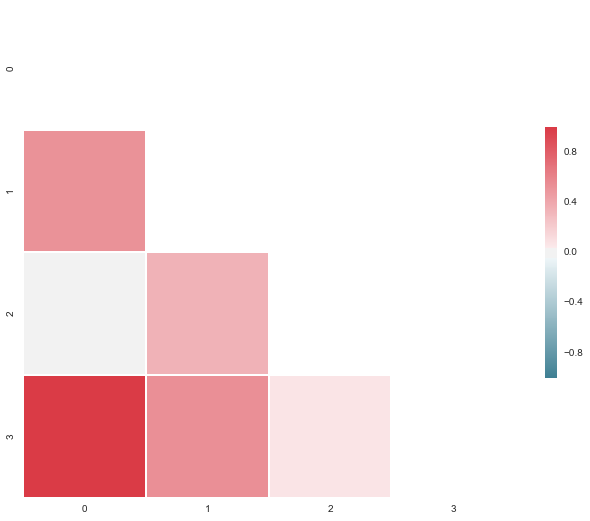

PlotData112:           0         1         2  3
0  1.000000  0.000000  0.000000  0
1  0.517998  1.000000  0.000000  0
2 -0.003284  0.347005  1.000000  0
3  0.996309  0.536772  0.076957  1
SimplePE: SP Writing [{'_d4p':           0         1         2  3
0  1.000000  0.000000  0.000000  0
1  0.517998  1.000000  0.000000  0
2 -0.003284  0.347005  1.000000  0
3  0.996309  0.536772  0.076957  1, 'TriggeredByProcessIterationID': 'PlotData-orfeus-as-99202-779ca897-5dc1-11e6-93ea-f45c89acf865', 'id': 'orfeus-as-99202-77de5387-5dc1-11e6-ac8c-f45c89acf865'}] to ('PlotData112', 'output')


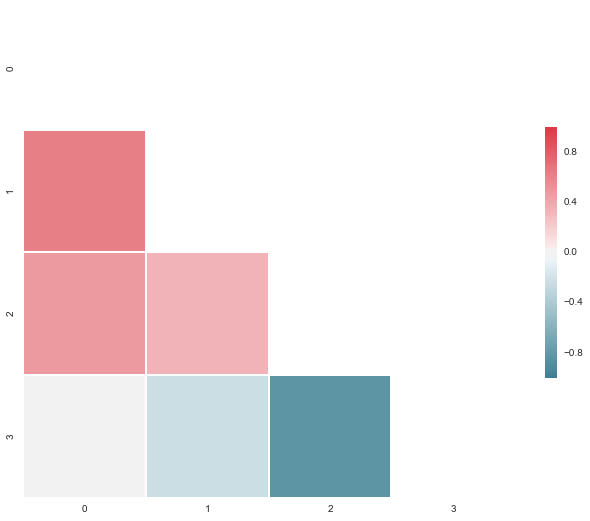

PlotData112:           0         1        2  3
0  1.000000  0.000000  0.00000  0
1  0.624630  1.000000  0.00000  0
2  0.481692  0.339899  1.00000  0
3 -0.025452 -0.227080 -0.82419  1
SimplePE: SP Writing [{'_d4p':           0         1        2  3
0  1.000000  0.000000  0.00000  0
1  0.624630  1.000000  0.00000  0
2  0.481692  0.339899  1.00000  0
3 -0.025452 -0.227080 -0.82419  1, 'TriggeredByProcessIterationID': 'PlotData-orfeus-as-99202-77defcbd-5dc1-11e6-9786-f45c89acf865', 'id': 'orfeus-as-99202-783bffcc-5dc1-11e6-ae0f-f45c89acf865'}] to ('PlotData112', 'output')


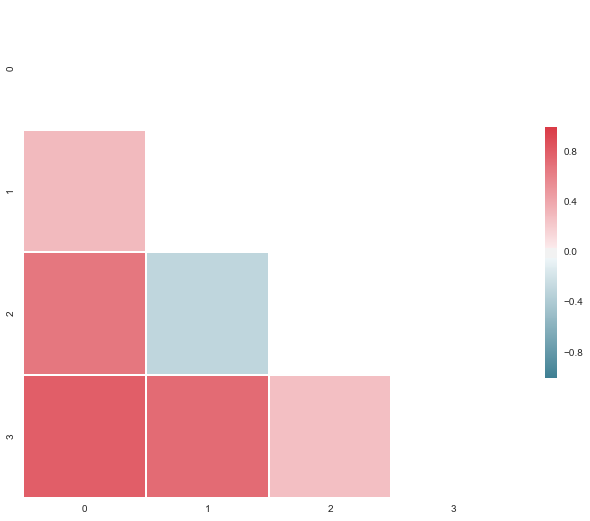

PlotData112:           0         1         2  3
0  1.000000  0.000000  0.000000  0
1  0.303456  1.000000  0.000000  0
2  0.670240 -0.296025  1.000000  0
3  0.798732  0.726604  0.278662  1
SimplePE: SP Writing [{'_d4p':           0         1         2  3
0  1.000000  0.000000  0.000000  0
1  0.303456  1.000000  0.000000  0
2  0.670240 -0.296025  1.000000  0
3  0.798732  0.726604  0.278662  1, 'TriggeredByProcessIterationID': 'PlotData-orfeus-as-99202-783cefcc-5dc1-11e6-829c-f45c89acf865', 'id': 'orfeus-as-99202-78a64ce3-5dc1-11e6-86e9-f45c89acf865'}] to ('PlotData112', 'output')
SimplePE: Processed 1 iteration.


{'PlotData112': {'output': [{'TriggeredByProcessIterationID': 'PlotData-orfeus-as-99202-779ca897-5dc1-11e6-93ea-f45c89acf865',
    '_d4p':           0         1         2  3
    0  1.000000  0.000000  0.000000  0
    1  0.517998  1.000000  0.000000  0
    2 -0.003284  0.347005  1.000000  0
    3  0.996309  0.536772  0.076957  1,
    'id': 'orfeus-as-99202-77de5387-5dc1-11e6-ac8c-f45c89acf865'},
   {'TriggeredByProcessIterationID': 'PlotData-orfeus-as-99202-77defcbd-5dc1-11e6-9786-f45c89acf865',
    '_d4p':           0         1        2  3
    0  1.000000  0.000000  0.00000  0
    1  0.624630  1.000000  0.00000  0
    2  0.481692  0.339899  1.00000  0
    3 -0.025452 -0.227080 -0.82419  1,
    'id': 'orfeus-as-99202-783bffcc-5dc1-11e6-ae0f-f45c89acf865'},
   {'TriggeredByProcessIterationID': 'PlotData-orfeus-as-99202-783cefcc-5dc1-11e6-829c-f45c89acf865',
    '_d4p':           0         1         2  3
    0  1.000000  0.000000  0.000000  0
    1  0.303456  1.000000  0.000000  0
    2  

In [19]:
#Launch in simple process
process_and_return(graph, input_data)

## Developing ProvenanceRecorders

The Class below show a sample <i>ProvenanceRecorderToService</i> and a slightlty more advanced one that allows for feedback.

### ProvenanceRecorderToService

Recieves traces from the PEs and sends them out to an exteranal provenance store.



In [20]:

class ProvenanceRecorderToService(ProvenanceRecorder):

    def __init__(self, name='ProvenanceRecorderToService', toW3C=False):
        ProvenanceRecorder.__init__(self)
        self.name = name
        self.convertToW3C = toW3C
        # self.inputconnections[ProvenanceRecorder.INPUT_NAME] = {
        # "name": ProvenanceRecorder.INPUT_NAME}

    def _preprocess(self):
        self.provurl = urlparse(ProvenanceRecorder.REPOS_URL)
        self.connection = httplib.HTTPConnection(
            self.provurl.netloc)

    def _process(self, inputs):
        
        #ports are assigned automatically as numbers, we just need to read from any of these
        for x in inputs:
            prov = inputs[x]
            
        out = None
        if isinstance(prov, list) and "data" in prov[0]:
            prov = prov[0]["data"]

        if self.convertToW3C:
            out = toW3Cprov(prov)
        else:
            out = prov

        params = urllib.urlencode({'prov': json.dumps(out)})
        headers = {
            "Content-type": "application/x-www-form-urlencoded",
            "Accept": "application/json"}
        self.connection.request(
            "POST",
            self.provurl.path,
            params,
            headers)

        response = self.connection.getresponse()
        print("Response From Provenance Serivce: ", response.status,
              response.reason, response, response.read())
        self.connection.close()
        return None

    def postprocess(self):
        self.connection.close()



### MyProvenanceRecorderWithFeedback

Recieves traces from the PEs and reads its content. Depending from the 'name' of the PE sending the lineage, feedbacks are prepared and sent back.

In [21]:

class MyProvenanceRecorderWithFeedback(ProvenanceRecorder):

    def __init__(self, toW3C=False):
        ProvenanceRecorder.__init__(self)
        self.convertToW3C = toW3C
        self.bulk = []
        self.timestamp = datetime.datetime.utcnow()

    def _preprocess(self):
        self.provurl = urlparse(ProvenanceRecorder.REPOS_URL)

        self.connection = httplib.HTTPConnection(
            self.provurl.netloc)

    def postprocess(self):
        self.connection.close()
        
    def _process(self, inputs):
        prov = None
        for x in inputs:
            prov = inputs[x]
        out = None
        if isinstance(prov, list) and "data" in prov[0]:
            prov = prov[0]["data"]

        if self.convertToW3C:
            out = toW3Cprov(prov)
        else:
            out = prov

            
            
        self.write(self.porttopemap[prov['name']], "FEEDBACK MESSAGGE FROM RECORDER")

        self.bulk.append(out)
        params = urllib.urlencode({'prov': json.dumps(self.bulk)})
        headers = {
            "Content-type": "application/x-www-form-urlencoded",
            "Accept": "application/json"}
        self.connection.request(
            "POST", self.provurl.path, params, headers)
        response = self.connection.getresponse()
        self.log("progress: " + str((response.status, response.reason,
                                         response, response.read())))
        

        return None

## Active provenance with feedback
Here we show how to implement a PE that can handle feedback from a <i>ProvenanceRecoder</i>. We redefine the worklow graph with the same structure as the provious one but with the new PE

### Class DivFeedback
It requires the implementation of the <i>_process_feedbak</i> function. The function will be invoked automatically by the framework when a feedback is sent.
<br/>

In [22]:
class DivFeedback(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output')
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'self.prov_cluster='mycluster'
         
         
        
    def _process_feedback(data):
        print "FEEEEDBACK: "+str(data)
    
    def _process(self,data):
        self.log("DIIIIV: "+str(data)) 
        val = data['input'][0]/data['input'][1]
        self.write('output',val,metadata={'val':val})

        
        


### Preparing the Workflow with the requires clusters, recorders and feedback 

SETTING NAME: PlotData
SETTING NAME: Start
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
Preparing for: 3 projections


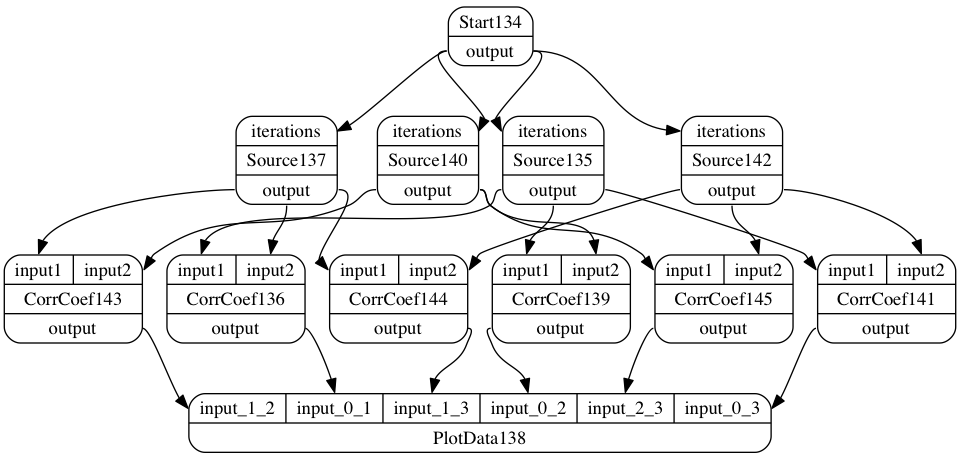

SETTING NAME: NewWorkflowRun
SETTING NAME: ProvenanceRecorderToServiceBulk
Inputs: {'NewWorkflowRun': [{'input': 'None'}]}
SETTING NAME: SimpleProcessingPE
RUN Metadata: {'username': 'aspinuso', 'workflowId': 'xx', 'description': '', 'mapping': '-f', 'system_id': None, 'runId': 'RDWD_orfeus-as-99202-800c1a82-5dc1-11e6-80de-f45c89acf865', 'startTime': '2016-08-08 23:40:33.975920', 'input': [], '_id': 'RDWD_orfeus-as-99202-800c1a82-5dc1-11e6-80de-f45c89acf865', 'type': 'workflow_run', 'workflowName': 'test_rdwd'}
SimplePE: Processed 1 iteration.
Outputs: {}
Change grouping implementation 
Change grouping implementation 
Injecting provenance to: CorrCoef Original type: (<class 'dispel4py.core.GenericPE'>,)
Injecting provenance to: CorrCoef Transoformed: <class 'dispel4py.provenance.<class '__main__.CorrCoef'>'>
Change grouping implementation 
Injecting provenance to: CorrCoef Original type: (<class 'dispel4py.core.GenericPE'>,)
Injecting provenance to: CorrCoef Transoformed: <class 'dispe

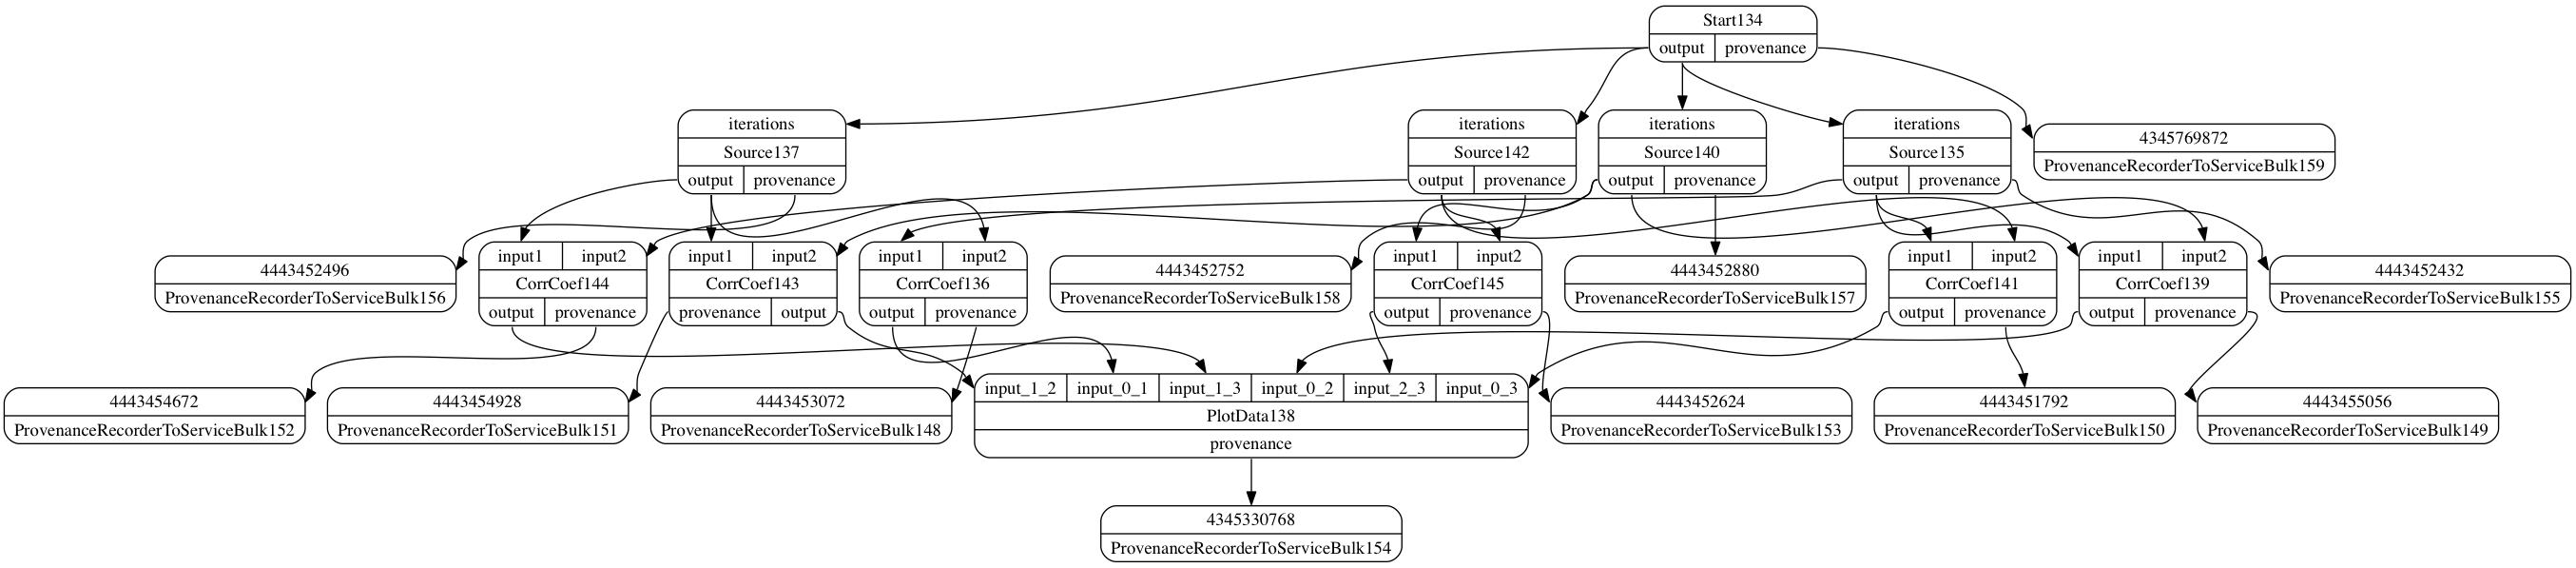

In [23]:
# Instantiates the Workflow Components        


# Instantiates the Workflow Components  
# and generates the graph based on parameters

sources={}
graph = WorkflowGraph()
plot=PlotData(variables_number)    
start=Start()   

#Recoreders' dictionary
clustersRecorders={}

for i in range(0,variables_number):
    sources[i] = Source(sampling_rate,i)
    #sources[i].prov_cluster='mycluster_src'
    clustersRecorders['mycluster_src']=MyProvenanceRecorderWithFeedback
        
    

for h in range(0,variables_number):
    graph.connect(start,'output',sources[h],'iterations')
    for j in range(h+1,variables_number):
        cc=CorrCoef(batch_size,(h,j))
        plot._add_input('input'+'_'+str(h)+'_'+str(j),grouping=[1])
        graph.connect(sources[h],'output',cc,'input1')
        graph.connect(sources[j],'output',cc,'input2')
        #sources[h].prov_cluster='mycluster_'+str(h)
        #sources[j].prov_cluster='mycluster_'+str(j)
        #cc.prov_cluster='mycluster_xcorr'
        
        #Associates recorders to clusters
        graph.connect(cc,'output',plot,'input'+'_'+str(h)+'_'+str(j))
        clustersRecorders['mycluster_xcorr']=MyProvenanceRecorderWithFeedback
        

#Visualise the graph
from dispel4py.visualisation import display

print ("Preparing for: "+str(iterations/batch_size)+" projections" )


from IPython.display import HTML
HTML('Simple Graph <br/>')
display(graph)

# Preparing the workflow graph for provenance production, pre-analysis and storage
# Ranomdly generated unique identifier for the current run
rid='RDWD_'+getUniqueId()

# if ProvenanceRecorderToFile is used, this path will contains all the resulting JSON documents
os.environ['PROV_PATH']="./prov-files/"

# Finally, provenance enhanced graph is prepared:
InitiateNewRun(graph,ProvenanceRecorderToServiceBulk,provImpClass=ProvenancePE,username='aspinuso',runId=rid,w3c_prov=False,workflowName="test_rdwd",workflowId="xx",clustersRecorders=clustersRecorders)
#feedbackPEs=['Source','CorrCoef'])

#.. and visualised..

display(graph)

### Execution with Feedback
As a temporary requirement, feedback workflows have to bee executed in multiprocessing mode
<br/>


In [24]:
#Launch in multi process

import argparse
from dispel4py.new.multi_process import process

args = argparse.Namespace
args.num = 24
args.simple = False
process(graph, inputs=input_data, args=args)


#process_and_return(graph, input_data)

Processes: {'ProvenanceRecorderToServiceBulk157': [13], 'ProvenanceRecorderToServiceBulk156': [11], 'ProvenanceRecorderToServiceBulk155': [1], 'ProvenanceRecorderToServiceBulk154': [17], 'ProvenanceRecorderToServiceBulk153': [9], 'ProvenanceRecorderToServiceBulk152': [22], 'ProvenanceRecorderToServiceBulk151': [4], 'ProvenanceRecorderToServiceBulk150': [14], 'ProvenanceRecorderToServiceBulk159': [16], 'ProvenanceRecorderToServiceBulk158': [15], 'CorrCoef139': [8], 'Source135': [20], 'CorrCoef136': [5], 'Start134': [6], 'Source140': [2], 'Source142': [10], 'ProvenanceRecorderToServiceBulk148': [23], 'ProvenanceRecorderToServiceBulk149': [0], 'PlotData138': [19], 'CorrCoef145': [3], 'CorrCoef144': [12], 'Source137': [21], 'CorrCoef141': [18], 'CorrCoef143': [7]}
Start134 (rank 6): Processed 1 iteration.
Source140 (rank 2): Processed 1 iteration.
Source142 (rank 10): Processed 1 iteration.
CorrCoef139 (rank 8): Processed 30 iterations.
CorrCoef145 (rank 3): Processed 30 iterations.
CorrCo